### Observations about the problem

- This problem is characterized by its vast state space and the scarcity of the reward that exists only when reaching the solved state if we don't introduce knowledge into the model. We could potentially introduce at one point a reward function that gives information about the quality of the current state.

- The system is deterministic and we know all the transitions of it. 

### We decide for now to not introduce any knowledge and have a reward of 1 if reaching the solved state and -1 else


### Important points on why we can't simply do Q Learning with this method:

1) We need the initial position to be close to the solved state else it will be impossible for the agent to get to this state (the only one giving a reward) given the extremely vast state space.
    -> We take as a distance to the solved state the number of random shuffles that are done from it.

2) The system is completely deterministic and we know all the transitions. It is thus better to work by updating the state_values instead of the q_values as it is 6x smaller (6 actions possible for a 2x2 rubiks cube).

3) We can't do full episodes as if the agent explores / goes into an unseen part of the rubiks cube he is very likely to get "lost" in it and do thousands of iterations before arriving to the solved state if it even reaches it. 



### The solution ADI (Auto Didactic Iteration) (https://arxiv.org/pdf/1805.07470.pdf)

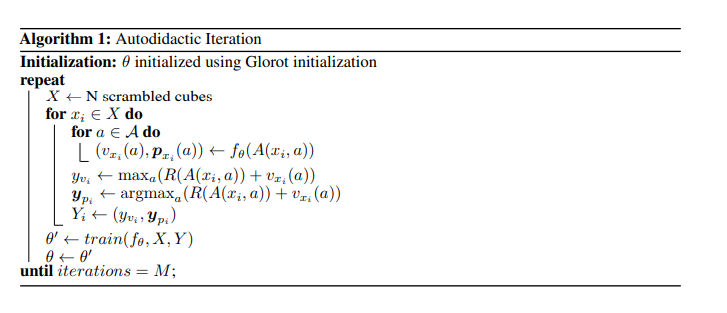

## Imports

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import torch.nn as nn
import random
from tqdm.notebook import tqdm
from torch.optim.lr_scheduler import _LRScheduler
from typing import List, Callable, Tuple
import collections
import gymnasium as gym
from gymnasium import spaces
import pygame
from cube import CubeEnv

## Environnement

In [36]:
# Setup cuda/cpu device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Set the device to CUDA if available, otherwise use CPU
print(f"PyTorch will train neural networks on {device}")

PyTorch will train neural networks on cpu


In [37]:
env = CubeEnv(device=device)
env.reset()
print(env._get_obs())
# env.reset()
# env.shuffle(25)

tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.])


## Modèle utilisé comme contrôleur

In [38]:
# Source: TD6 INF581
CUBE_SIZE=2

n_input  = 6 * 6 * CUBE_SIZE * CUBE_SIZE # 6 = nombre de faces // size^2 = nombre de couleurs par face // 6 = one-hot encoding des couleurs
n_output = 1
n_dense  = 256 # au pif, un pax avait choisi 1024 pour le 3x3



class ADINetwork(torch.nn.Module):
    def __init__(self):
        super(ADINetwork, self).__init__()
        
        self.l1 = nn.Linear(n_input, n_dense)
        self.l2 = nn.Linear(n_dense, n_dense)
        self.l3 = nn.Linear(n_dense, n_dense)
        self.l4 = nn.Linear(n_dense, n_output)
        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.l1(x)
        x = self.relu(x)
        x = self.l2(x)
        x = self.relu(x)
        x = self.l3(x)
        x = self.relu(x)
        x = self.l4(x)
        return x

## Policy

In [74]:
class GreedyPolicy:
    
    def __init__(self,adi_network: torch.nn.Module,gamma:float):
        self.adi_network = adi_network
        self.gamma=gamma

    def __call__(self, env: CubeEnv,states:torch.tensor=None) -> np.int64:
        batch_size = states.shape[0]
        batched_argmax = torch.zeros(states.shape[0],dtype=torch.int64)
        batched_values = torch.zeros(states.shape[0])
        for i in range(batch_size):
            state_tensor=states[i]
            state=env.from_tensor_to_state(state_tensor)
            state_values = []
            for a in range(6) :
                state_tensor,reward,_,_,_ =env.simulate_step(state,a)     
                with torch.no_grad():
                    state_values.append(reward+self.gamma*self.adi_network(state_tensor).item())
            state_values=torch.tensor(state_values)
            argmax = torch.argmax(state_values).item()
            batched_argmax[i]=argmax
            batched_values[i]=state_values[argmax]
        return batched_argmax, batched_values

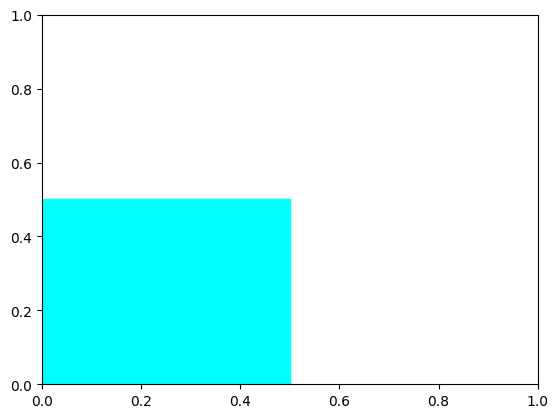

In [75]:
fig, ax = plt.subplots()
rect = patches.Rectangle((0, 0), width=.5, height=.5, color='aqua')
ax.add_patch(rect)
fig.canvas.draw()

## Learning rate scheduler

In [76]:
class MinimumExponentialLR(torch.optim.lr_scheduler.ExponentialLR):
    
    def __init__(self, optimizer: torch.optim.Optimizer, lr_decay: float, last_epoch: int = -1, min_lr: float = 1e-6):
        self.min_lr = min_lr
        super().__init__(optimizer, lr_decay, last_epoch=-1)

    def get_lr(self):
        return [
            max(base_lr * self.gamma ** self.last_epoch, self.min_lr)
            for base_lr in self.base_lrs
        ]

## Train function

In [96]:
#TODO: Include batch size
def train_adi(env: CubeEnv,
                     adi_network: torch.nn.Module,
                     optimizer: torch.optim.Optimizer,
                     loss_fn: Callable,
                     greedy_policy: GreedyPolicy,
                     device: torch.device,
                     lr_scheduler: _LRScheduler,
                     batch_size: int,
                     num_episodes,
                     num_shuffles: int, #How deep we shuffle the rubiks cube
                     ) -> List[float]:
    iteration = 0

    for episode in tqdm(range(0,num_episodes,batch_size)) :
        env.reset()
        states=env.shuffle(num_shuffles,batch_size=batch_size)
        #The first dimension of states corresponds to the shuffle steps.(num_shuffles,batch_size,n_input)
        for n_shuffle,shuffle_step in enumerate(states) :
            _,target_value=greedy_policy(env,shuffle_step)
            estimated_value=adi_network(shuffle_step)
            #Rescaling to avoid degenaracy
            rescaled_target=target_value/(n_shuffle+1)
            rescaled_estimated=estimated_value/(n_shuffle+1)
            loss = loss_fn(rescaled_estimated, rescaled_target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            iteration += 1
        if episode % 128 == 0:
            print(f"Episode {episode} - Loss: {loss.item()}")


## Train it

In [114]:
gamma=0.9
num_episodes=1000
batch_size=32
num_shuffles=4
adi_network = ADINetwork().to(device) # q network

optimizer = torch.optim.AdamW(adi_network.parameters(), lr=0.004, amsgrad=True)
#lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
lr_scheduler = MinimumExponentialLR(optimizer, lr_decay=0.97, min_lr=0.0001)
loss_fn = torch.nn.MSELoss()

greedy_policy = GreedyPolicy(adi_network=adi_network, gamma=gamma)


# Train the adi network
episode_reward_list = train_adi(env,adi_network,optimizer,loss_fn,greedy_policy,device,lr_scheduler,batch_size,num_episodes,num_shuffles)


# Save the action-value estimation function
torch.save(adi_network, "adi_network.pth")

  0%|          | 0/32 [00:00<?, ?it/s]

Episode 0 - Target value: tensor([0.2174, 0.2260, 0.2287, 0.1999, 0.2213, 0.2439, 0.1992, 0.2329, 0.1988,
        0.2428, 0.2247, 0.2082, 0.1991, 0.2275, 0.2127, 0.2179, 0.1927, 0.2147,
        0.2325, 0.2210, 0.2209, 0.2139, 0.2161, 0.1951, 0.2059, 0.1968, 0.2195,
        0.2318, 0.2267, 0.2287, 0.2294, 0.1991]) - Estimated value: tensor([[0.2377],
        [0.2289],
        [0.2472],
        [0.2006],
        [0.2590],
        [0.2170],
        [0.2288],
        [0.2209],
        [0.2058],
        [0.2381],
        [0.2328],
        [0.2115],
        [0.2018],
        [0.2268],
        [0.2395],
        [0.2185],
        [0.2223],
        [0.1852],
        [0.2275],
        [0.2566],
        [0.2264],
        [0.2325],
        [0.2337],
        [0.2034],
        [0.2222],
        [0.2119],
        [0.2315],
        [0.2129],
        [0.2237],
        [0.2237],
        [0.2109],
        [0.1967]], grad_fn=<AddmmBackward0>) - Loss: 3.1035444408189505e-05
Episode 160 - Target value: tens

In [106]:
adi_network=torch.load("adi_network.pth")

In [107]:
def try_solve(env,n_move,max_iter=20,display=False) :
    env.reset(n_move)
    for i in range(max_iter) :
        action,value=greedy_policy(env,env._get_obs().unsqueeze(0))
        state,reward,_,_,_ =env.step(action.item())
        if display :
            print(f"Action {action} value {value} reward {reward}")
        if reward==1 :
            return True, i+1
    return False, max_iter


In [108]:
def compute_acc(env,n_samples,n_move,max_iter=20) :
    success=0
    n_iter=0
    for i in range(n_samples) :
        solved,_=try_solve(env,n_move,max_iter)
        if solved :
            success+=1
    return success/n_samples

In [109]:
try_solve(env,2)

(True, 2)

In [110]:
compute_acc(env,100,2)

0.2

In [111]:
def plot_acc(env,n_samples,max_move,max_iter=20) :
    accs=[]
    for i in range(1,max_move+1) :
        acc=compute_acc(env,n_samples,i)
        accs.append(acc)
    plt.plot(list(range(1,max_move+1)),accs)
    plt.xlabel("Number of shuffles")
    plt.ylabel("Accuracy")
    plt.title("Accuracy of the greedy policy")
    plt.show()

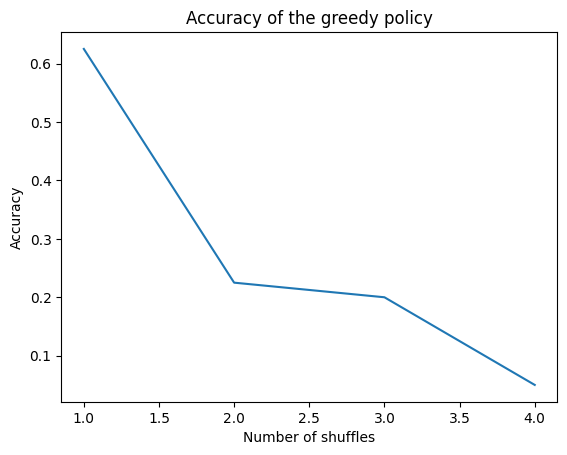

In [113]:
plot_acc(env,40,4)